# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# SAC


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import glob
import gc
import os
import os.path
import time
import tempfile
import random
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'p2_continuous-control/results')
SEEDS = (1)

%matplotlib inline

### Q-Function:

In [4]:
class QNet(nn.Module):
    def __init__(self,
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(QNet, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u,
                             device=self.device,
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action) -> torch.Tensor:
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

### Policy-Function:

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, 
                 input_dim, 
                 action_bounds,
                 log_std_min=-20, 
                 log_std_max=2,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 entropy_lr=0.001):
        super(PolicyNet, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.action_shape = self.env_max.cpu().numpy().shape
        
        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = float(-np.prod(self.env_max.shape))
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, 
                                self.log_std_min, 
                                self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - \
                   torch.log((1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def select_random_action(self):
        return np.random.uniform(low=self.env_min.cpu().numpy(),
                                 high=self.env_max.cpu().numpy()).reshape(self.action_shape)

    def select_greedy_action(self, state):
        return self.rescale_fn(torch.tanh(self.forward(state)[0])).detach().cpu().numpy().reshape(self.action_shape)

    def select_action(self, state):
        mean, log_std = self.forward(state)
        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        return action.detach().cpu().numpy().reshape(self.action_shape)

    

### Replay Buffer:

In [6]:
class ReplayBuffer:
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.state_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.action_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.reward_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_state_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.is_done_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        state, action, reward, next_state, is_done = sample
        self.state_mem[self._idx] = state
        self.action_mem[self._idx] = action
        self.reward_mem[self._idx] = reward
        self.next_state_mem[self._idx] = next_state
        self.is_done_mem[self._idx] = is_done
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.state_mem[idxs]), \
                      np.vstack(self.action_mem[idxs]), \
                      np.vstack(self.reward_mem[idxs]), \
                      np.vstack(self.next_state_mem[idxs]), \
                      np.vstack(self.is_done_mem[idxs])
        return experiences

    def __len__(self):
        return self.size
    

### SAC-Algo.:

In [7]:
class SAC():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn,
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau,
                 root_dir):

        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

        self.tau = tau
        self.root_dir = root_dir

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        # policy loss
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s - current_q_sa).mean()

        # Q loss
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer_b.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action()
        else:
            action = self.policy_model.select_action(state)

        env_info = env.step(action[None, ...])[self.brain_name]
        new_state, reward, is_terminal = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
        experience = (state, action, reward, new_state, float(is_terminal))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        return new_state, is_terminal

    def update_value_networks(self, tau=None):
        tau = self.tau if tau is None else tau

        for target, online in zip(self.target_value_model_a.parameters(), 
                                  self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), 
                                  self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, env_name, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.env_name = env_name
        self.seed = seed
        self.gamma = gamma
        
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
        
        env = UnityEnvironment(file_name=env_name)
        self.brain_name = env.brain_names[0]       # get the default brain
        self.brain = env.brains[self.brain_name]
        env_info = env.reset(train_mode=True)[self.brain_name]
        nS, nA = env_info.vector_observations.shape[1], self.brain.vector_action_space_size
        action_bounds = [-1 for _ in range(nA)], [1 for _ in range(nA)]
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)

        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)

        self.update_value_networks()

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
                                                         self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
                                                         self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            env_info = env.reset(train_mode=True)[self.brain_name]
            state, is_terminal = env_info.vector_observations[0], False
            
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            for _ in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if is_terminal:
                    gc.collect()
                    break

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_reward >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'elapsed {}, episode {:04}, steps {:07}, '
            debug_message += 'ave_r 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ave_r 100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ave_eval 100 {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward of +30 over last 100 episodes \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))

        self.save_checkpoint('final', self.policy_model)
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            env_info = eval_env.reset(train_mode=True)[self.brain_name]
            s, d = env_info.vector_observations[0], False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                env_info = eval_env.step(a[None, ...])[self.brain_name]
                s, r, d = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.root_dir if episode_idx == 'final' else self.checkpoint_dir,
                                'model.{}.tar'.format(episode_idx)))

### Learning with SAC:

In [8]:
SEEDS = [1]
sac_results = []
best_agent, best_eval_score = None, float('-inf')
sac_root_dir = os.path.join(RESULTS_DIR, 'sac')
not os.path.exists(sac_root_dir) and os.makedirs(sac_root_dir)

for seed in SEEDS:
    environment_settings = {
        'env_name': 'data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64',
        'gamma': 0.99,
        'max_minutes': 300,
        'max_episodes': 10000,
        'goal_mean_100_reward': 30
    }

    policy_model_fn = lambda nS, bounds: PolicyNet(nS, bounds, hidden_dims=(64,64))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0005

    value_model_fn = lambda nS, nA: QNet(nS, nA, hidden_dims=(128,128))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0007

    replay_buffer_fn = lambda: ReplayBuffer(max_size=1000000, batch_size=256)
    n_warmup_batches = 10
    update_target_every_steps = 1
    tau = 0.005

    env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
                
    agent = SAC(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm,
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                n_warmup_batches,
                update_target_every_steps,
                tau,
                sac_root_dir)

    result, final_eval_score, training_time, wallclock_time = agent.train(env_name, 
                                                                          seed, 
                                                                          gamma, 
                                                                          max_minutes, 
                                                                          max_episodes, 
                                                                          goal_mean_100_reward)
    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent

sac_results = np.array(sac_results)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


elapsed 00:00:04, episode 0000, steps 0001001, ave_r 10 000.8±000.0, ave_r 100 000.8±000.0, ave_eval 100 000.4±000.0
elapsed 00:05:13, episode 0033, steps 0034034, ave_r 10 001.7±000.7, ave_r 100 001.1±000.8, ave_eval 100 001.1±000.7
elapsed 00:10:17, episode 0063, steps 0064064, ave_r 10 007.9±000.8, ave_r 100 002.9±002.6, ave_eval 100 003.0±002.9
elapsed 00:15:26, episode 0092, steps 0093093, ave_r 10 024.4±007.4, ave_r 100 008.0±009.0, ave_eval 100 007.8±008.9
elapsed 00:20:36, episode 0120, steps 0121121, ave_r 10 029.8±008.4, ave_r 100 015.2±012.0, ave_eval 100 015.3±012.4
elapsed 00:25:44, episode 0147, steps 0148148, ave_r 10 037.1±002.5, ave_r 100 024.2±011.7, ave_eval 100 023.6±011.4
elapsed 00:29:40, episode 0167, steps 0168168, ave_r 10 038.1±001.0, ave_r 100 030.0±009.1, ave_eval 100 029.3±008.6
--> reached_goal_mean_reward of +30 over last 100 episodes ✓
Training complete.
Final evaluation score 37.23±2.39 in 1576.27s training time, 1901.41s wall-clock time.



In [9]:
sac_max_total_steps, sac_max_100_reward, sac_max_100_score, \
sac_max_train_time, sac_max_wall_time = np.max(sac_results, axis=0).T

sac_min_total_steps, sac_min_100_reward, sac_min_100_score, \
sac_min_train_time, sac_min_wall_time = np.min(sac_results, axis=0).T

sac_mean_total_steps, sac_mean_100_reward, sac_mean_100_score, \
sac_mean_train_time, sac_mean_wall_time = np.mean(sac_results, axis=0).T

sac_x = np.arange(len(sac_mean_100_score))

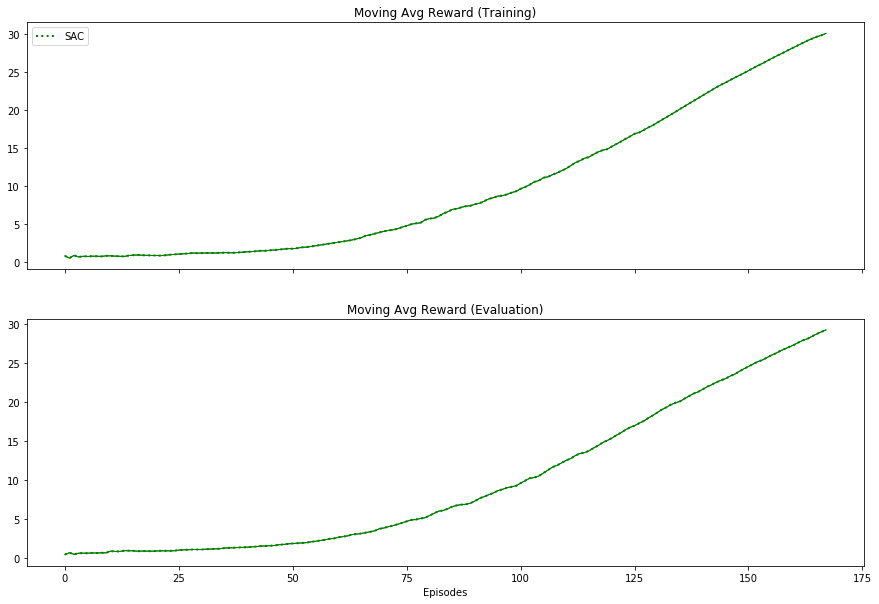

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_100_reward, 'g', linewidth=1)
axs[0].plot(sac_min_100_reward, 'g', linewidth=1)
axs[0].plot(sac_mean_100_reward, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_100_reward, sac_max_100_reward, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_100_score, 'g', linewidth=1)
axs[1].plot(sac_min_100_score, 'g', linewidth=1)
axs[1].plot(sac_mean_100_score, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_100_score, sac_max_100_score, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

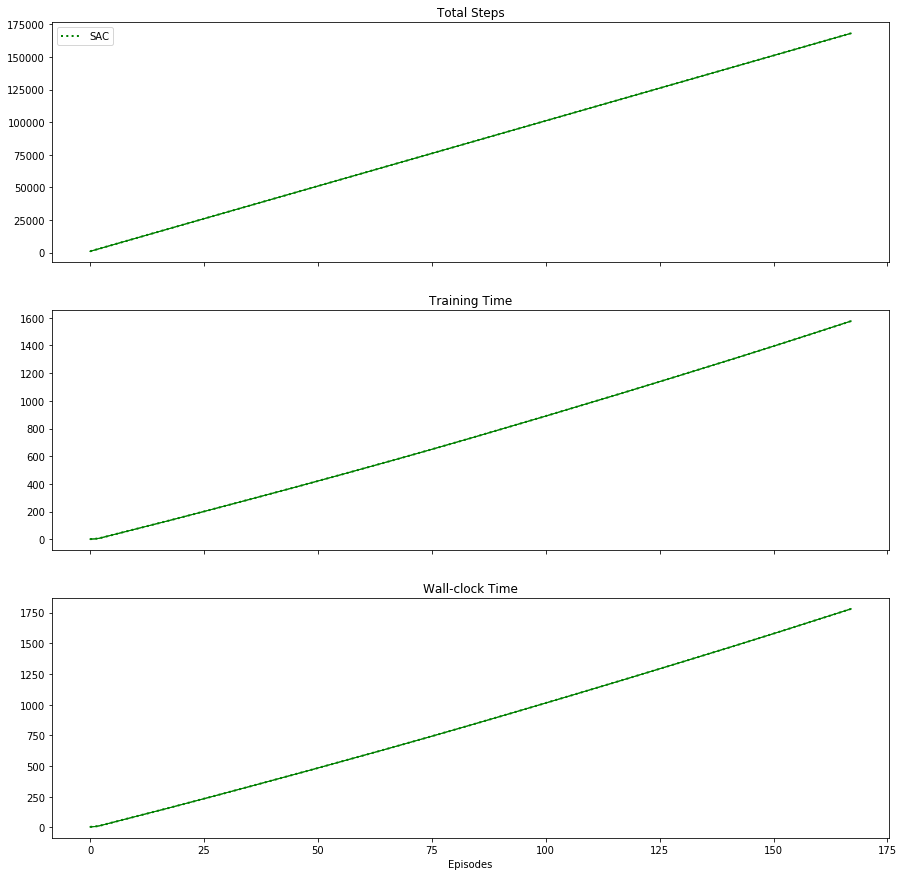

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_total_steps, 'g', linewidth=1)
axs[0].plot(sac_min_total_steps, 'g', linewidth=1)
axs[0].plot(sac_mean_total_steps, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_total_steps, sac_max_total_steps, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_train_time, 'g', linewidth=1)
axs[1].plot(sac_min_train_time, 'g', linewidth=1)
axs[1].plot(sac_mean_train_time, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_train_time, sac_max_train_time, facecolor='g', alpha=0.3)

axs[2].plot(sac_max_wall_time, 'g', linewidth=1)
axs[2].plot(sac_min_wall_time, 'g', linewidth=1)
axs[2].plot(sac_mean_wall_time, 'g:', label='SAC', linewidth=2)
axs[2].fill_between(
    sac_x, sac_min_wall_time, sac_max_wall_time, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [12]:
sac_stats_dict = {
    'x': sac_x,

    'max_100_reward': sac_max_100_reward,
    'min_100_reward': sac_min_100_reward,
    'mean_100_reward': sac_mean_100_reward,

    'max_100_score': sac_max_100_score,
    'min_100_score': sac_min_100_score,
    'mean_100_score': sac_mean_100_score,

    'max_total_steps': sac_max_total_steps,
    'min_total_steps': sac_min_total_steps,
    'mean_total_steps': sac_mean_total_steps,

    'max_train_time': sac_max_train_time,
    'min_train_time': sac_min_train_time,
    'mean_train_time': sac_mean_train_time,

    'max_wall_time': sac_max_wall_time,
    'min_wall_time': sac_min_wall_time,
    'mean_wall_time': sac_mean_wall_time
}

torch.save(sac_stats_dict, os.path.join(sac_root_dir, 'sac_stats_dict'))